In [59]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Data Pre processing

In [2]:
stock_train= pd.read_csv('Google_Stock_Price_Train.csv')


In [3]:
stock_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
#in this we are going to predict the stock price for begining of a finiancfial day

In [5]:
stock_training_set = stock_train.iloc[:,1:2].values #this will create a numpy array as we know

In [6]:
stock_training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

# Feature Scaling 

In [7]:
from sklearn.preprocessing import MinMaxScaler
#for stock price prediction we will be using normalization formula 

In [8]:
sc = MinMaxScaler(feature_range = (0,1))
#now we will be applying the sc object to our data to effictively apply this normalization

In [9]:
stock_training_set_scaled = sc.fit_transform(stock_training_set)
#here fit means that we are going to take the min and max and apply it to the normalization formula

In [10]:
stock_training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [11]:
#now we are going to implement a data structure specifying what RNN needs to remember when predicting the next stock-
#-price,this is called number of time steps

In [12]:
#we will create a data structure with 60 time steps and 1 output
#this means that at each time 't' the RNN will look at 60 stock price before time 't'. and based on the trend it is-
#-capturing during these 60 privious time steps it will try to predict the output. 

In [13]:
#this simply means that our RNN will try to learn from the privious 60 days of stock price and it will learn the -
#-co-relation or some trends and based on its understanding it will try to predict the stock price. The Rnn will-
#-predict the stock price at time 't+1'.

In [14]:
#now we need to create two entities,
#x-train which will be the input of the RNN 
#y-train which will be the output
#here x train will contain the privious 60 financial days of stock price data and the y-train will give us the stock-
#-price of the next financial day


# Data structure to implement the above description

In [15]:
x_train = []
y_train = []
for i in range(60,1258):
    x_train.append(stock_training_set_scaled[i-60:i,0])
    y_train.append(stock_training_set_scaled[i,0])
    #as these are list,we need to convert them to numpy array as so the RNN will accept the data
x_train,y_train = np.array(x_train),np.array(y_train)

In [16]:
x_train

array([[0.08581368, 0.09701243, 0.09433366, ..., 0.07846566, 0.08034452,
        0.08497656],
       [0.09701243, 0.09433366, 0.09156187, ..., 0.08034452, 0.08497656,
        0.08627874],
       [0.09433366, 0.09156187, 0.07984225, ..., 0.08497656, 0.08627874,
        0.08471612],
       ...,
       [0.92106928, 0.92438053, 0.93048218, ..., 0.95475854, 0.95204256,
        0.95163331],
       [0.92438053, 0.93048218, 0.9299055 , ..., 0.95204256, 0.95163331,
        0.95725128],
       [0.93048218, 0.9299055 , 0.93113327, ..., 0.95163331, 0.95725128,
        0.93796041]])

In [17]:
#here 0.08581368 is the stock price of 60th day followed by privious 60 days of stock price
#here 0.09701243 is the stock price of 61st day followed by privious 60 days of stock price

In [18]:
y_train


array([0.08627874, 0.08471612, 0.07454052, ..., 0.95725128, 0.93796041,
       0.93688146])

In [19]:
#now we will be adding dimension. this dimension we will add is exactly a unit i.e the number of predictors we can-
#-use to predict what we want i.e the stock price at time step t+1

In [20]:
#for adding new dimension we use reshape function

In [21]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

# Building The RNN

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [23]:
regressor = Sequential() #this will represent the sequence of layers

In [24]:
#Adding the first LSTM layer and some Dropout regularisation

In [29]:
#here return_sequences is TURE because we want to make a stacked LSTM layer,if you dont want a stacked layer keep it as False.
#input_shape contains last 2 dimensions corresponding to time step and indicators.
#input shape is only require for the first LSTM layer

In [30]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
#with this out LSTM layer is created now lets add dropout regularisation

In [31]:
regressor.add(Dropout(0.2))
#here 20% of 50 is 10 so 10 neurons will be dropped out for each iteration of training

In [32]:
#2nd LSTM layer
regressor.add(LSTM(units = 50 ,return_sequences = True))
regressor.add(Dropout(0.2))

In [33]:
#3rd LSTM layer
regressor.add(LSTM(units = 50 ,return_sequences = True))
regressor.add(Dropout(0.2))

In [34]:
#4th LSTM layer
#since this will be our last LSTM layer the return sequence will be False
regressor.add(LSTM(units = 50 ,return_sequences = False))
regressor.add(Dropout(0.2))

In [35]:
#Output layer

#since our output layer will be fully connected to the LSTM layers we need to use the DENSE class.
#the units will be equal to dimension of output layer which is 1 i.e the stock price at time t+1

In [36]:
regressor.add(Dense(units = 1))

# Compiling the RNN


In [37]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#as this is a regression problem we use loss as mean squared error

# Fitting the RNN with Training Set

In [38]:
regressor.fit(x_train,y_train,epochs = 100,batch_size = 32)

Epoch 1/100
38/38 [==============================] - 22s 195ms/step - loss: 0.0452
Epoch 2/100
38/38 [==============================] - 7s 187ms/step - loss: 0.0100
Epoch 3/100
38/38 [==============================] - 7s 188ms/step - loss: 0.0067
Epoch 4/100
38/38 [==============================] - 7s 194ms/step - loss: 0.0069
Epoch 5/100
38/38 [==============================] - 7s 194ms/step - loss: 0.0059
Epoch 6/100
38/38 [==============================] - 7s 195ms/step - loss: 0.0060
Epoch 7/100
38/38 [==============================] - 8s 203ms/step - loss: 0.0066
Epoch 8/100
38/38 [==============================] - 10s 254ms/step - loss: 0.0059
Epoch 9/100
38/38 [==============================] - 9s 228ms/step - loss: 0.0062
Epoch 10/100
38/38 [==============================] - 8s 204ms/step - loss: 0.0053
Epoch 11/100
38/38 [==============================] - 7s 197ms/step - loss: 0.0048
Epoch 12/100
38/38 [==============================] - 8s 198ms/step - loss: 0.0053
Epoch 13/10

38/38 [==============================] - 6s 151ms/step - loss: 0.0015
Epoch 100/100
38/38 [==============================] - 6s 152ms/step - loss: 0.0013


# Making the predictions

In [ ]:
#getting the real stock price of 2017

In [39]:
stock_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = stock_test.iloc[:,1:2].values

In [41]:
#Getting the predicted stock price

In [43]:
dataset_total = pd.concat((stock_train['Open'],stock_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total)-len(stock_test)-60:].values
#here the len(dataset_total) will be the last day of january 2017 and the len(data_test) = 20, so this will give us january 3rd-
#2017 which will be the first financial day of Jan 2017, and 60 is subtracted because we see the last 60 days stock price to-
#predict the new stock price

In [44]:
#the trick to reshape inputs is use reshape function of numpy

In [46]:
inputs = inputs.reshape(-1,1)

In [48]:
#with this we will get the inputs with differnt stock prices of january 3rd -3months in an inline column

In [ ]:
#Now lets scale our inputs

In [49]:
inputs = sc.transform(inputs)

In [55]:
#for each stock price of the day we will get the privious stock price  of 60 days 
x_test = []
for i in range(60,80):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)

In [56]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [57]:
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 3s 3s/step


# Visualizing the results

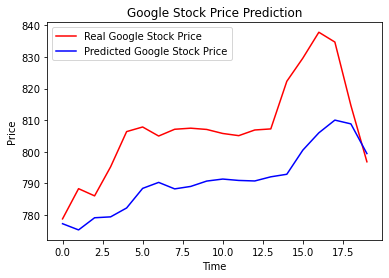

In [64]:
#real google stock price of Jan 2017
plt.plot(real_stock_price, color='red',label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()